In [4]:
import pandas as pd
from utilities import load_data
richness_df, metadata_df = load_data()

In [5]:
metadata_df.columns

Index(['no_campagne', 'date_complete', 'insee_commune', 'nom_commune',
       'code_dept', 'site_officiel', 'x_theo', 'y_theo',
       'classe_mat1p_million_dexpert', 'libelle_mat1p_million_dexpert',
       'classe_mat2p_million_dexpert', 'libelle_mat2p_million_dexpert',
       'classe_mat3p_million_dexpert', 'libelle_mat3p_million_dexpert',
       'rp_95_nom', 'rp_2008_nom', 'rp_95_ger', 'signific_ger_95',
       'rp_2008_ger', 'signific_ger_2008', 'occupation1',
       'desc_code_occupation1', 'occupation3', 'desc_code_occupation3',
       'land_use', 'name', 'group', 'wrb_guess', 'water_regime',
       'parent_material', 'carbonate', 'magnesic', 'dolomitic', 'saline',
       'organic', 'clayey', 'sandy', 'stony', 'vertic', 'shallow', 'anthropic',
       'volcanic', 'truncated', 'cemented', 'base_saturation',
       'qualifier_notes', 'classe_simplifiee'],
      dtype='object')

Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\map\map_france_land_use.png
Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\map\map_france_parent_material.png
Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\map\map_france_wrb_class.png
Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\map\map_france_soil_class.png
Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\map\map_france_soil_type.png


KeyError: 'soil_class'

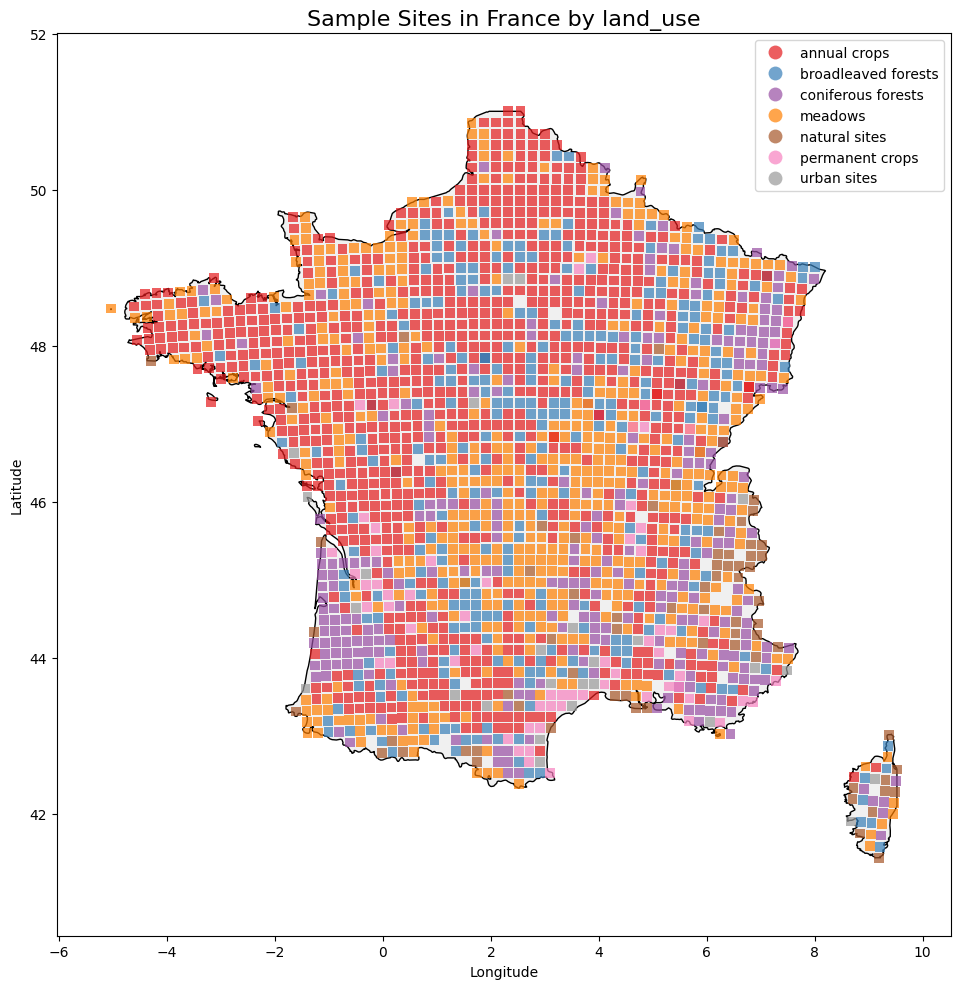

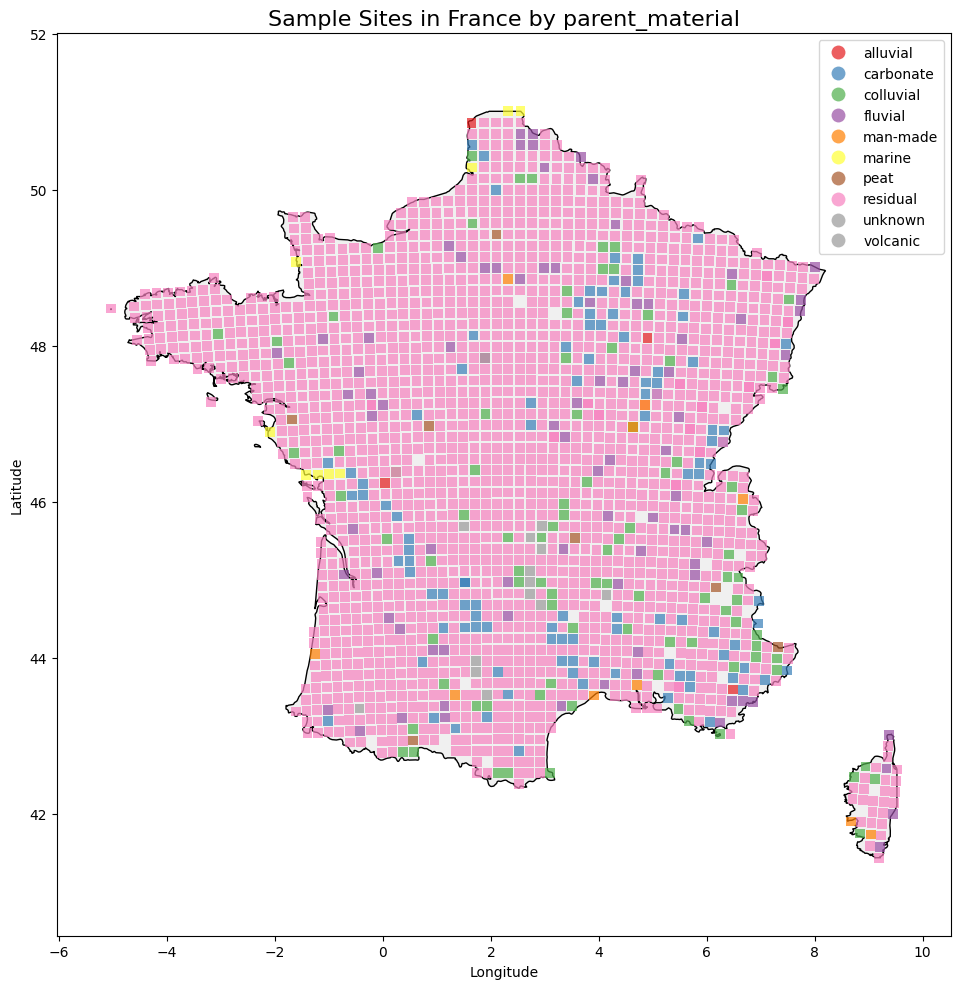

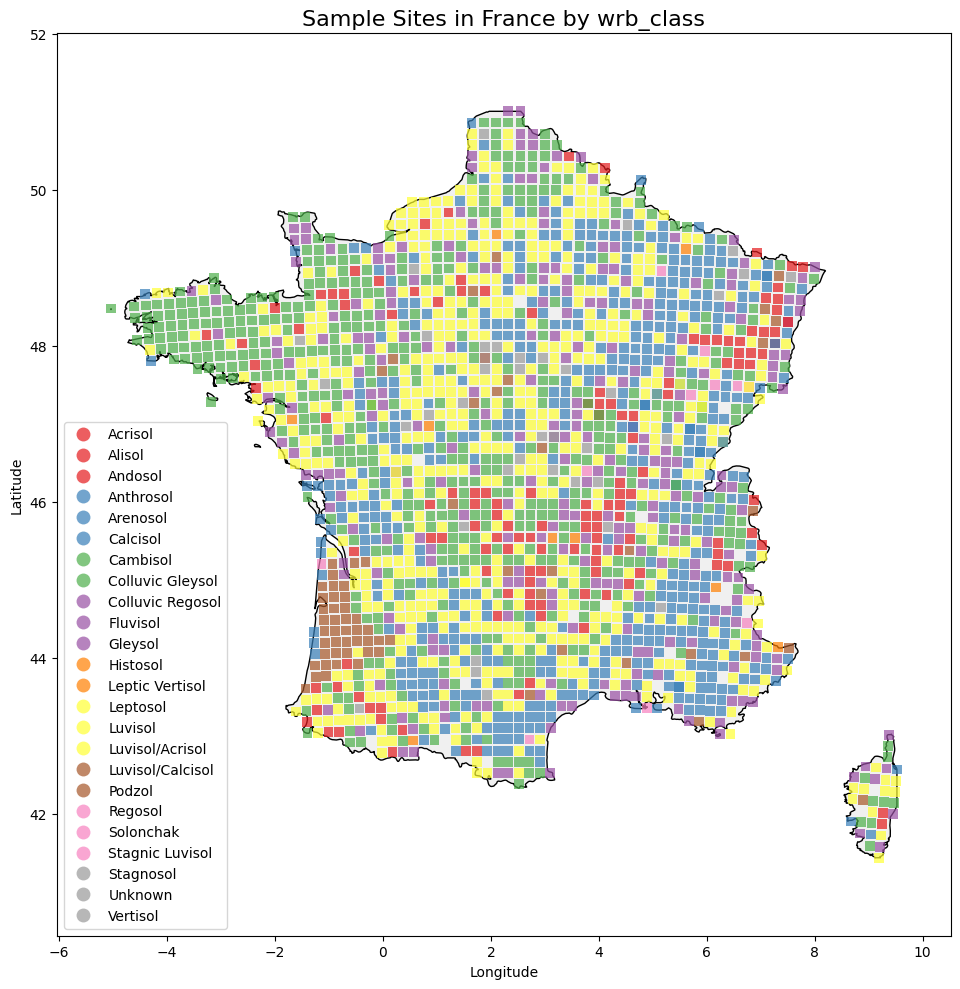

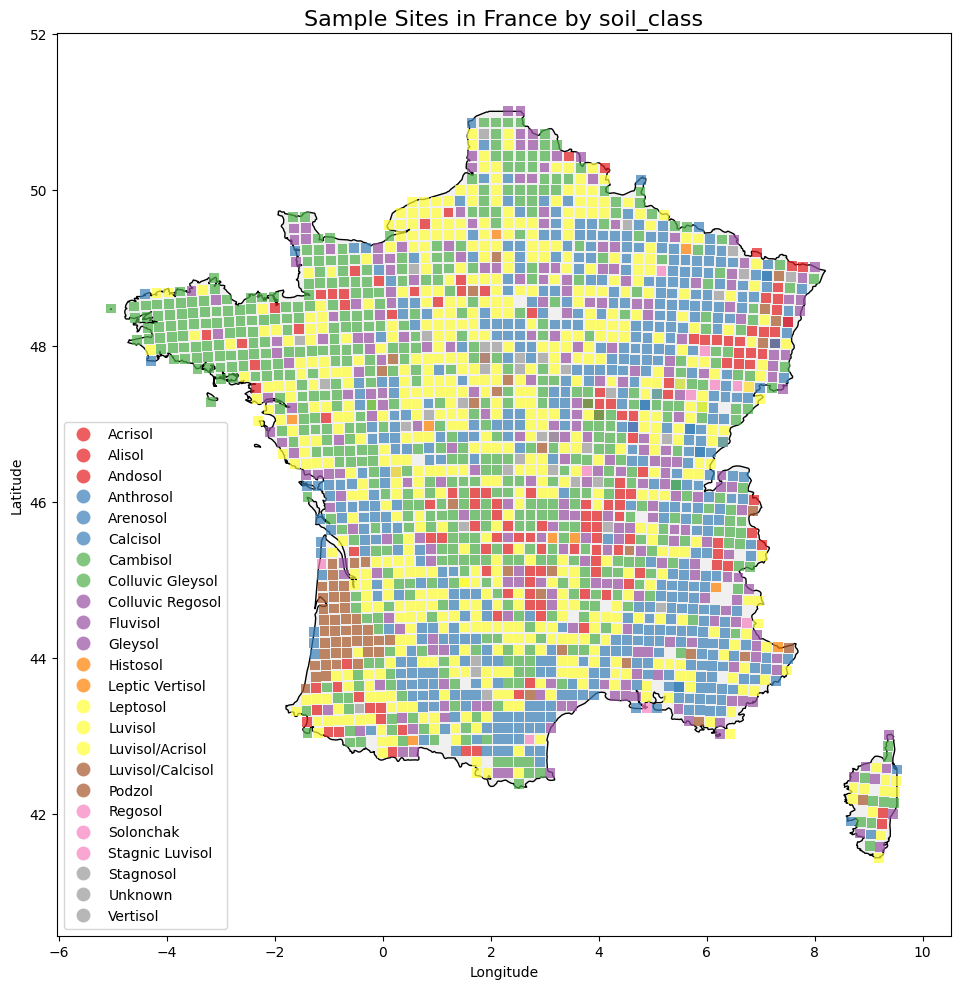

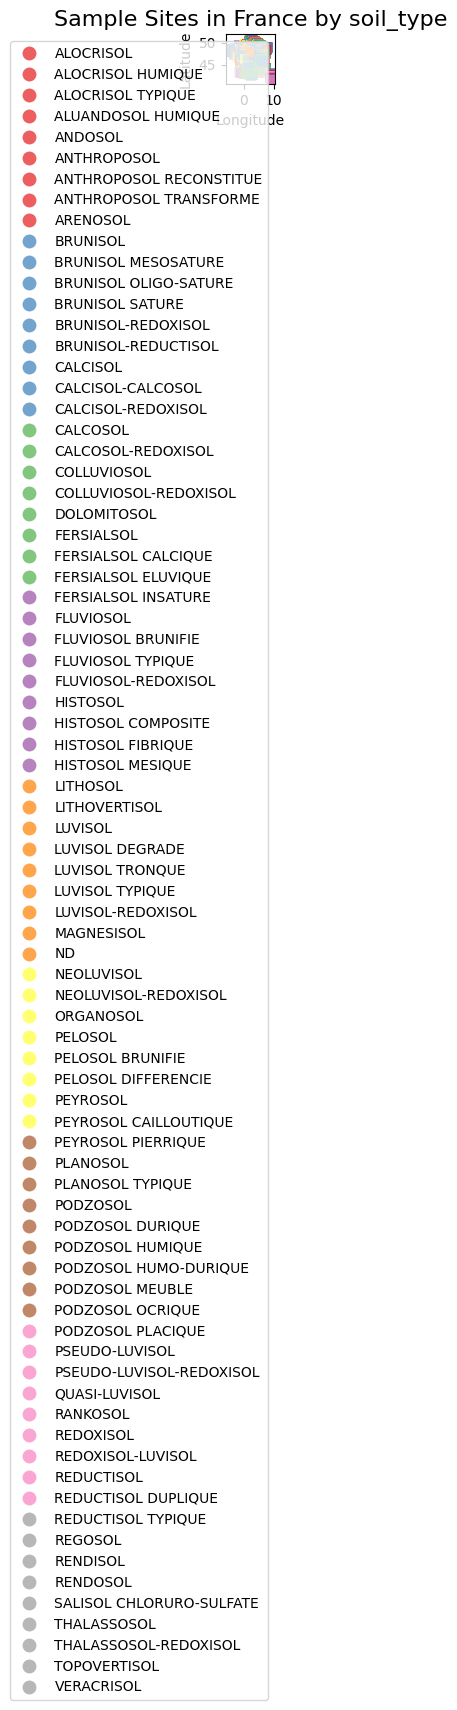

In [ ]:
import plot_distribution
import plot_map
import plot_heatmap
"""
plot_distribution.main("otu_richness", "land_use", 'land_use')
plot_distribution.main("otu_richness", "parent_material", 'parent_material')
plot_distribution.main("otu_richness", "wrb_guess", 'wrb_class')
plot_distribution.main("otu_richness", "signific_ger_95", 'soil_type')
plot_distribution.main("otu_richness", "desc_code_occupation3", 'land_use_fine')
"""

plot_map.main("land_use", 'land_use')
plot_map.main("parent_material", 'parent_material')
plot_map.main("wrb_guess", 'soil_type_wrb')
plot_map.main("signific_ger_95", 'soil_type')
plot_map.main("", 'land_use_fine')

plot_heatmap.main("otu_richness", ["land_use", "land_use"], ['wrb_guess', "soil_class"])